In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns


def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + './HAR/UCI/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + './HAR/UCI/')
    
    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    #one hot encode y
    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

In [3]:
X_train, y_train, y_train_one_hot, X_test, y_test, y_test_one_hot = load_dataset()

(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


In [4]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_one_hot.shape[1]

In [5]:
n_timesteps, n_features, n_outputs

(128, 9, 6)

In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from keras.layers import concatenate
from keras.utils import to_categorical

In [8]:
##Level_1
# layer 1
inputs1_1= Input(shape=(n_timesteps,n_features))##128,9
conv1_1 = Conv1D(filters=128, kernel_size=3, activation='relu')(inputs1_1) ##none,126,128
# layer 2
inputs1_2= Input(shape=(n_timesteps,n_features))
conv1_2 = Conv1D(filters=128, kernel_size=5, activation='relu')(inputs1_2)##124,128
# layer 3
inputs1_3= Input(shape=(n_timesteps,n_features))
conv1_3 = Conv1D(filters=128, kernel_size=7, activation='relu')(inputs1_3)##122,128
# layer 4
inputs1_4= Input(shape=(n_timesteps,n_features))
conv1_4 = Conv1D(filters=128, kernel_size=9, activation='relu')(inputs1_4)##120,128

# merge1
merged_1 = concatenate([conv1_1,conv1_2,conv1_3,conv1_4],axis=1)

#maxpool1
pool_1=MaxPooling1D(pool_size=5)(merged_1)

##Level_2
# layer 1
conv2_1 = Conv1D(filters=64, kernel_size=3, activation='relu')(pool_1)
# layer 2
conv2_2 = Conv1D(filters=64, kernel_size=5, activation='relu')(pool_1)
# layer 3
conv2_3 = Conv1D(filters=64, kernel_size=7, activation='relu')(pool_1)
# layer 4

conv2_4 = Conv1D(filters=64, kernel_size=9, activation='relu')(pool_1) 
# merge2
merged_2 = concatenate([conv2_1,conv2_2,conv2_3,conv2_4],axis=1)

#maxpool2
pool_2=MaxPooling1D(pool_size=5)(merged_2)


from tensorflow.keras.layers import LSTM

# ...

# LSTM layer
lstm1 = LSTM(64, return_sequences=True)(pool_2)  # You can adjust the number of units (64) as needed
lstm2 = LSTM(64)(lstm1)

# ...

# Dense layer
dense = Dense(512, activation='relu')(lstm2)
outputs = Dense(n_outputs, activation='softmax')(dense)

# ...

# Create the model
cnn_lstm_model = Model([inputs1_1, inputs1_2, inputs1_3, inputs1_4], outputs)

# Compile the model
cnn_lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Summary of the model
cnn_lstm_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 128, 9)]             0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 128, 9)]             0         []                            
                                                                                                  
 input_7 (InputLayer)        [(None, 128, 9)]             0         []                            
                                                                                                  
 input_8 (InputLayer)        [(None, 128, 9)]             0         []                            
                                                                                              

In [11]:
# fit network
model_history=cnn_lstm_model.fit(x=[X_train,X_train,X_train,X_train], y=y_train_one_hot, epochs=30, batch_size=32,validation_data= ([X_test,X_test,X_test,X_test],y_test_one_hot))


Epoch 1/30
230/230 [==============================] - 24s 87ms/step - loss: 0.4302 - accuracy: 0.8206 - val_loss: 0.4576 - val_accuracy: 0.8734
Epoch 2/30
230/230 [==============================] - 19s 83ms/step - loss: 0.1491 - accuracy: 0.9414 - val_loss: 0.3477 - val_accuracy: 0.8982
Epoch 3/30
230/230 [==============================] - 19s 85ms/step - loss: 0.1269 - accuracy: 0.9457 - val_loss: 0.3704 - val_accuracy: 0.8989
Epoch 4/30
230/230 [==============================] - 20s 86ms/step - loss: 0.1030 - accuracy: 0.9546 - val_loss: 0.4032 - val_accuracy: 0.9135
Epoch 5/30
230/230 [==============================] - 20s 87ms/step - loss: 0.1162 - accuracy: 0.9520 - val_loss: 0.2901 - val_accuracy: 0.9009
Epoch 6/30
230/230 [==============================] - 20s 88ms/step - loss: 0.1125 - accuracy: 0.9521 - val_loss: 0.2844 - val_accuracy: 0.9074
Epoch 7/30
230/230 [==============================] - 20s 86ms/step - loss: 0.1182 - accuracy: 0.9513 - val_loss: 0.3855 - val_accuracy:

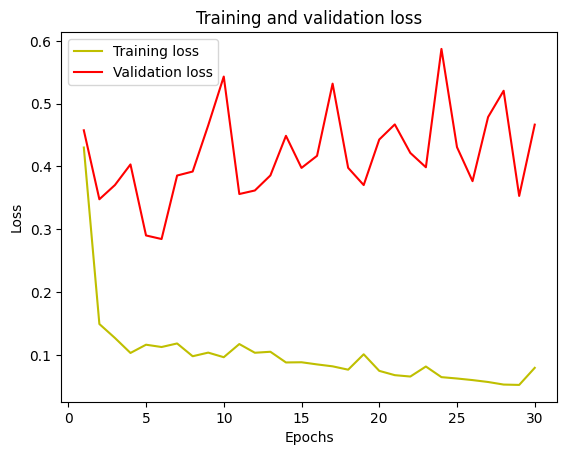

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

loss =model_history.history['loss']
val_loss =model_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

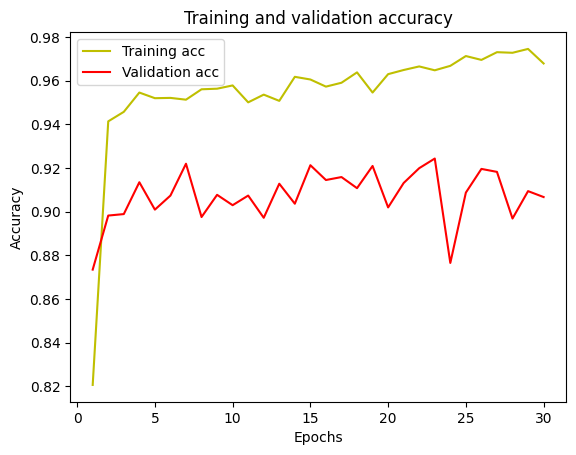

In [13]:
acc =model_history.history['accuracy']
val_acc =model_history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

93/93 [==============================] - 2s 23ms/step
[[468   1  27   0   0   0]
 [  3 445  23   0   0   0]
 [  0   7 413   0   0   0]
 [  0  23   0 393  73   2]
 [  3   1   0 112 416   0]
 [  0   0   0   0   0 537]]
0.9066847641669494
              precision    recall  f1-score   support

           0       0.99      0.94      0.96       496
           1       0.93      0.94      0.94       471
           2       0.89      0.98      0.94       420
           3       0.78      0.80      0.79       491
           4       0.85      0.78      0.81       532
           5       1.00      1.00      1.00       537

    accuracy                           0.91      2947
   macro avg       0.91      0.91      0.91      2947
weighted avg       0.91      0.91      0.91      2947



<Axes: >

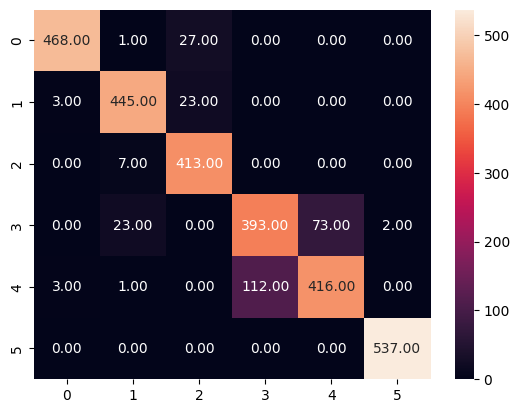

In [17]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
pred=cnn_lstm_model.predict([X_test,X_test,X_test,X_test])
pred=np.argmax(pred, axis=-1)
cm=confusion_matrix(y_test,pred)
print(cm)
print(accuracy_score(y_test,pred))
print(classification_report(y_test,pred))
sns.heatmap(cm, annot=True, fmt = '.2f')